/var/folders/vm/_zft15050r7cfh47y6v5z4k40000gn/T/ipykernel_56366/3642582570.py:63: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(response.text)[0]


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

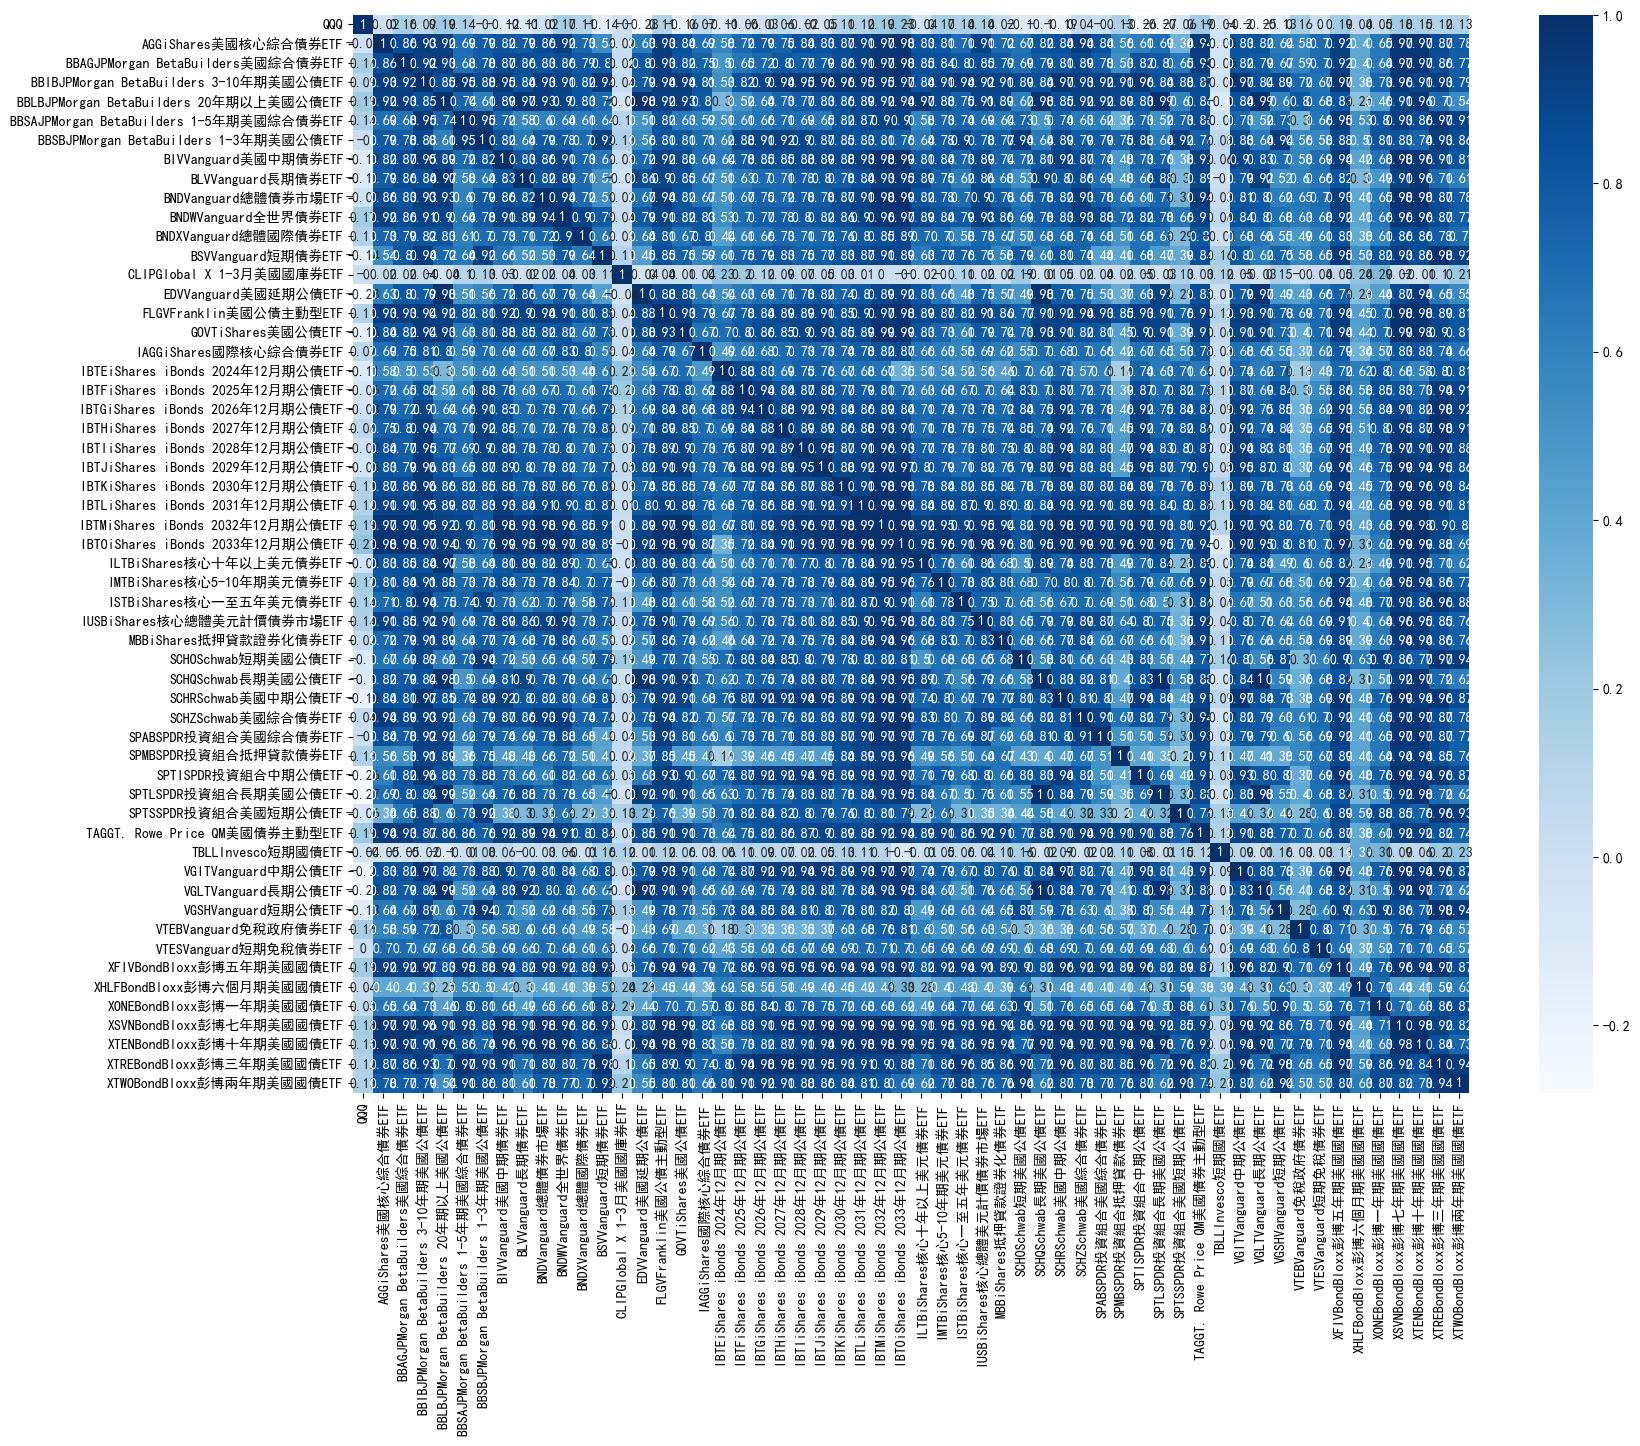

[*********************100%%**********************]  1 of 1 completed
                 QQQ      IBTD
Date                          
2020-02-26  1.005154  1.000000
2020-02-27  0.949926  1.000000
2020-02-28  1.000778  1.000000
2020-03-02  1.051604  1.000000
2020-03-03  0.967933  1.000000
...              ...       ...
2023-12-15  1.004834  1.000404
2023-12-18  1.006299  1.000000
2023-12-19  1.005110  1.000000
2023-12-20  0.985140  1.000000
2023-12-21  1.011635  1.000000

[964 rows x 2 columns]
商品:QQQ 權重:0.5
商品:IBTD 權重:0.5
投資組合年化報酬:0.10040137868516386
投資組合風險:7.46722037135858e-05


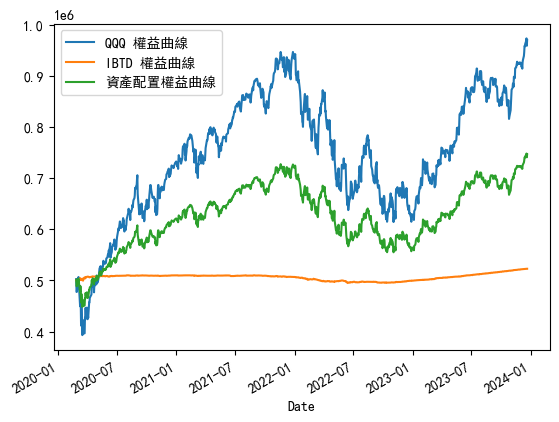

In [1]:
"""
美元股債資產配置(基礎)
1. 找出股債相關性
2. 分配資產配置比例 
3. 取得相關資產資料
4. 資產配置風險報酬計算 
5. 資產配置權益曲線圖
6. 尋找最好的股債比
"""

# 載入函數工具檔
from Data import getDataYF, getMultipleReturn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False


# 資產配置風險報酬計算
def PortfolioRiskReturnRatio(getDataFunction, asset_allocation, price_column, cap):

    # 抓到所有歷史報酬率
    ret_dataframe = getMultipleReturn(
        getDataFunction, list(asset_allocation.keys()), price_column
    )
    ret_dataframe = ret_dataframe.dropna()
    print(ret_dataframe)

    # 年化風險報酬計算
    ann_ret = (ret_dataframe).prod() ** (252 / ret_dataframe.count()) - 1
    w = list(asset_allocation.values())
    weight_ann_ret = (ann_ret * w).sum()
    cov = (ret_dataframe).cov()
    weight_ann_risk = (
        cov.mul(asset_allocation, axis=0).mul(asset_allocation, axis=1).sum().sum()
    )

    # 顯示投資組合風險與報酬
    for key, value in asset_allocation.items():
        print(f"商品:{key} 權重:{value}")
    print(f"投資組合年化報酬:{weight_ann_ret}")
    print(f"投資組合風險:{weight_ann_risk}")

    # 資產配置 權益曲線計算
    cap_df = ret_dataframe.copy()
    cap_df["mix"] = 0
    for prod in asset_allocation.keys():
        # 計算單商品權益曲線
        cap_df[prod] = cap * (ret_dataframe[prod].cumprod())
        cap_df[prod].plot(label=f"{prod} 權益曲線", legend=True)
        # 分配資產比例
        cap_df["mix"] += cap_df[prod] * asset_allocation[prod]
    # 繪製資產配置的權益曲線圖
    cap_df["mix"].plot(label="資產配置權益曲線", legend=True)


# 取出常見全世界債券ETF
url = "https://www.moneydj.com/etf/eb/ET305001list.djhtm?Z=2&S=6&M=0&N=&A=24&B=&C=&D=&E=&F=&G=&H=&I=&J=&K=&L=&O=&P=&Q=&T=&U=100&X=&Y=&EB=&order=4&SS=&CC=&st=&EFX=&AP=&R="
response = requests.get(url)
df = pd.read_html(response.text)[0]
bond_df = df[(df["幣別"] == "美元") & (df["管理費(%)"] < 0.1)]

bond_list = bond_df["代碼"].to_list()

# 抓到所有歷史報酬率
ret_dataframe = getMultipleReturn(getDataYF, ["QQQ"] + bond_list, "adj close")
# 將商品代碼換成商品名稱
bond_name_list = (bond_df["代碼"] + bond_df["ETF名稱"]).to_list()
ret_dataframe.columns = ["QQQ"] + bond_name_list

# 計算相關性
corr = round(ret_dataframe.corr(), 2)

# 並繪製熱力圖
plt.figure(figsize=(18, 14))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

# 股債資產配置比例
asset_allocation = {"QQQ": 0.50, "IBTD": 0.50}

# 計算投資組合風險報酬
PortfolioRiskReturnRatio(getDataYF, asset_allocation, "adj close", 500000)
